# 02 - Extracción de descriptores clásicos para radiografías de tórax

## Introducción

En este notebook abordamos la **Parte 2** del proyecto de clasificación de imágenes médicas: la representación matemática de radiografías de tórax para el diagnóstico de neumonía mediante descriptores de forma y de textura.

Los descriptores permiten comparar, clasificar, reconocer o analizar objetos sin necesidad de usar la imagen completa, esto es útil para:

- Reconocer objetos
- Clasificar objetos
- Detectar anomalías 
- Reducir la información para hacer el procesamiento más rápido

## Objetivos de Este Notebook

1. Obtener y visualizar los descriptores HOG
2. Calcular los 7 momentos invarientes usando momentos de Hu
3. Obtener descriptores de contorno (Área, perímetro, circularidad, excentricidad)
4. Visualizar histograma de patrones obtenido con Local Binary Patterns (LBP)
5. Calcular con Gray Level Co-occurrence Matrix (GLCM) diversas propiedades para describir texturas
6. Filtrar imagénes usando filtros de Gabor y obtener las estadísticas de respuesta (media, desviación estándar)

In [12]:
# Importaciones principales y configuración
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
from skimage.feature import hog

# Ajustes de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Reproducibilidad
np.random.seed(42)

# Añadir src al path para importaciones relativas
project_root = Path('..').resolve()
src_path = project_root / 'src'
sys.path.append(str(src_path))

print(f"Ruta del proyecto detectada: {project_root}")

Ruta del proyecto detectada: C:\Users\Andres Churio\Documents\TRABAJO-03


## Estructura Esperada del Dataset

Se asume que el dataset de Kaggle fue descargado y descomprimido en `data/raw/`. Estructura típica del dataset original:

```
data/raw/chest_xray/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/
```

Para la extracción de descriptores nos concentramos en la carpeta `train/`.

In [13]:
# Definición de rutas
DATA_ROOT = Path('../data/raw/chest_xray')
TRAIN_DIR = DATA_ROOT / 'train'
NORMAL_DIR = TRAIN_DIR / 'NORMAL'
PNEUMONIA_DIR = TRAIN_DIR / 'PNEUMONIA'

print("Directorio base dataset:", DATA_ROOT)
print("¿Existe dataset?", DATA_ROOT.exists())
print("¿Existe directorio train?", TRAIN_DIR.exists())

Directorio base dataset: ..\data\raw\chest_xray
¿Existe dataset? True
¿Existe directorio train? True


In [14]:
# Importar módulos personalizados

from descriptors import (
    get_hog,
    extract_hu_moments,
    segment_image,
    contour_descriptors,
    load_image,
    compute_lbp,
    glcm_manual,
    glcm_props,
    apply_gabor,
    gabor_bank
)

print("✓ Módulos personalizados importados correctamente")

✓ Módulos personalizados importados correctamente


## Descriptores de forma - Histogram of Oriented Gradients (HOG)

El descriptor basado en el histograma de gradientes orientados HOG describe como cambian las intensidades en toda la imagén, lo que permite detectar bordes e indicar hacia que dirección apunta el mismo, lo cual es clave para representar formas sin importar la calidad de la iluminación.

In [15]:
# Recorrer todas las imágenes del dataset train y extraer descriptores HOG
classes = ["NORMAL", "PNEUMONIA"]

X = []    # features
y = []    # labels: 0 = normal, 1 = pneumonia

for class_name in classes:
    class_folder = os.path.join(TRAIN_DIR, class_name)

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Extraer HOG
        features, hog_image = get_hog(
            img,
            orientations=9,
            pixels_per_cell=(16, 16)
        )

        X.append(features)
        y.append(1 if class_name == "PNEUMONIA" else 0)

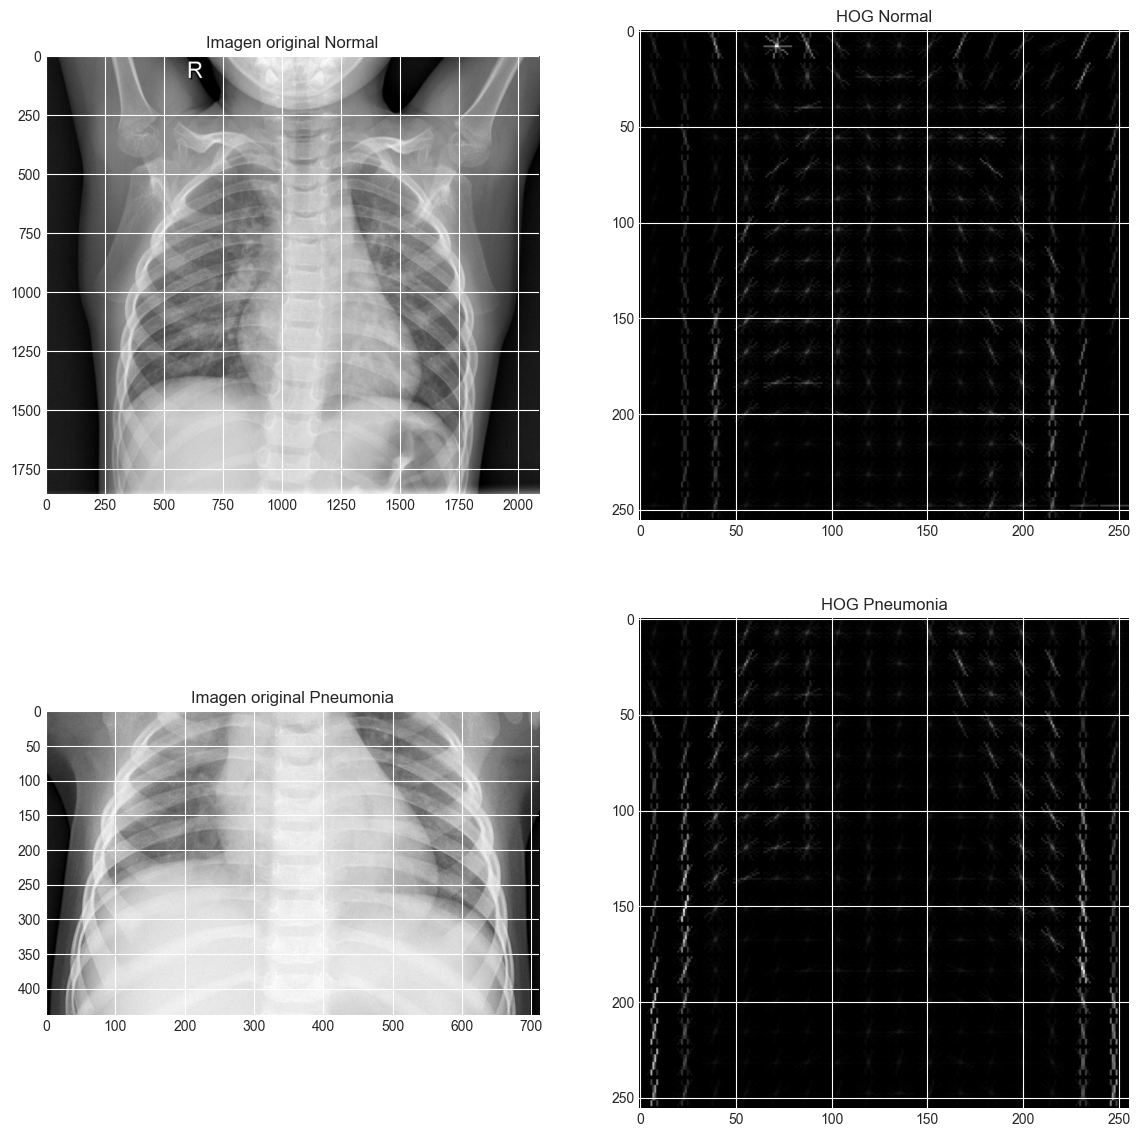

In [16]:
# Para realizar la visualización del HOG se toma la primera imagen del grupo normal y del grupo neumonía
example_path_n = NORMAL_DIR/"IM-0115-0001.jpeg"
img_example_n = cv2.imread(example_path_n, 0)

# Se utilizan 9 bins de orientación y un tamaño de celda 16x16 porque son valores típicos en la literatura

features_n, hog_img_n = get_hog(
    img_example_n,
    orientations=9,
    pixels_per_cell=(16, 16)
)

example_path_p = PNEUMONIA_DIR/"person1_bacteria_1.jpeg"
img_example_p = cv2.imread(example_path_p, 0)

features_p, hog_img_p = get_hog(
    img_example_p,
    orientations=9,
    pixels_per_cell=(16, 16)
)

plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.imshow(img_example_n, cmap='gray')
plt.title("Imagen original Normal")

plt.subplot(2,2,2)
plt.imshow(hog_img_n, cmap='gray')
plt.title("HOG Normal")

plt.subplot(2,2,3)
plt.imshow(img_example_p, cmap='gray')
plt.title("Imagen original Pneumonia")

plt.subplot(2,2,4)
plt.imshow(hog_img_p, cmap='gray')
plt.title("HOG Pneumonia")


plt.show()

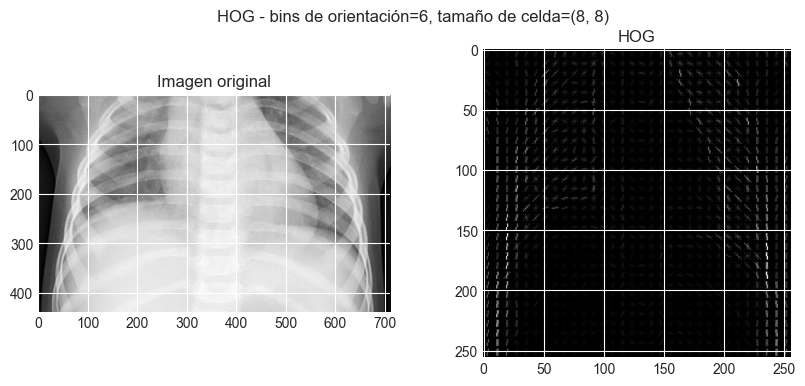

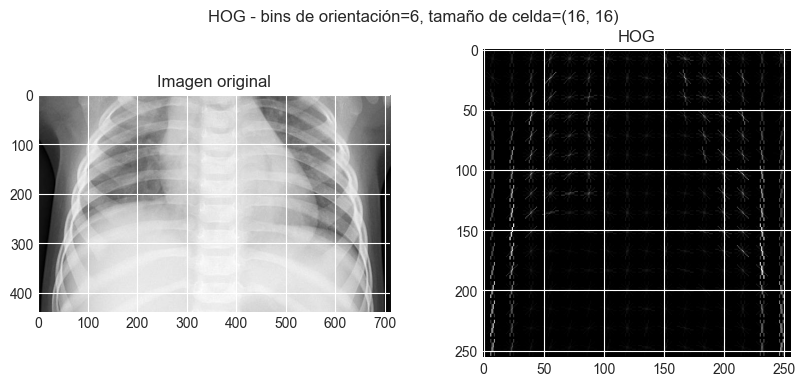

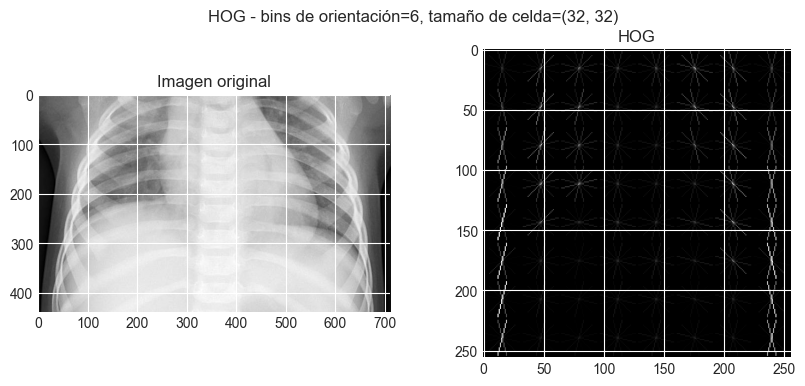

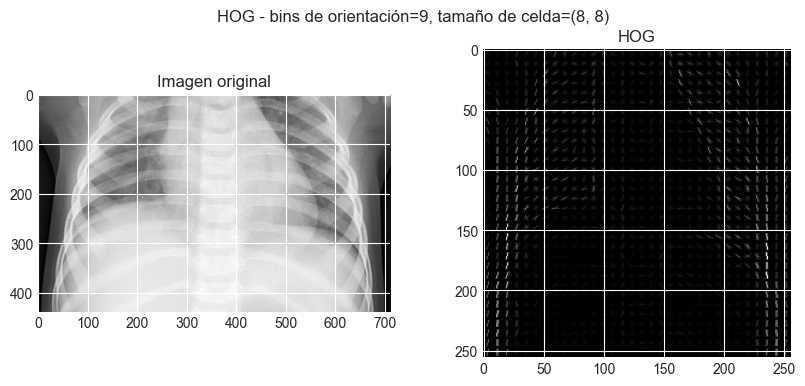

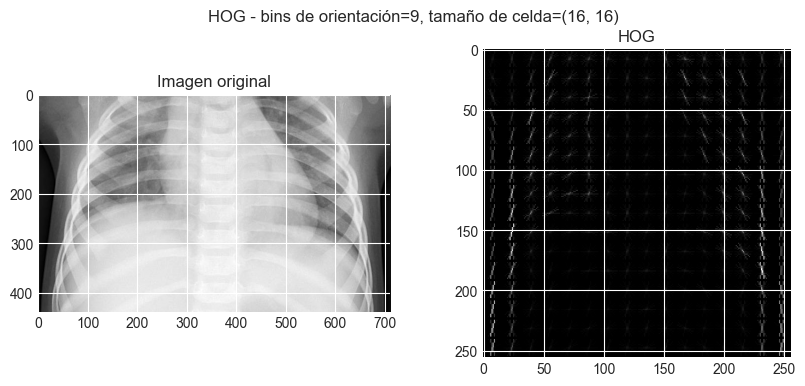

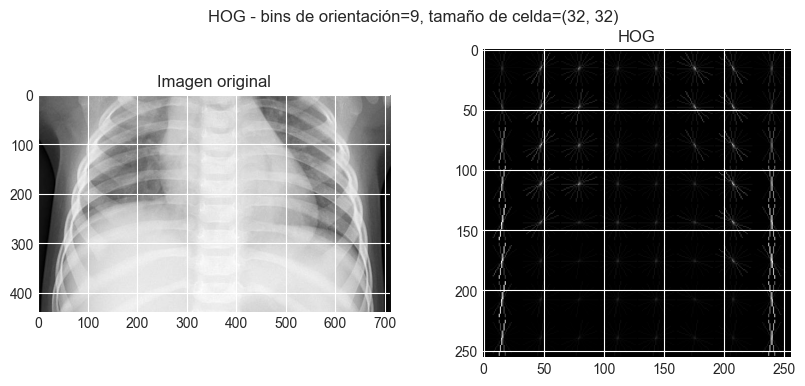

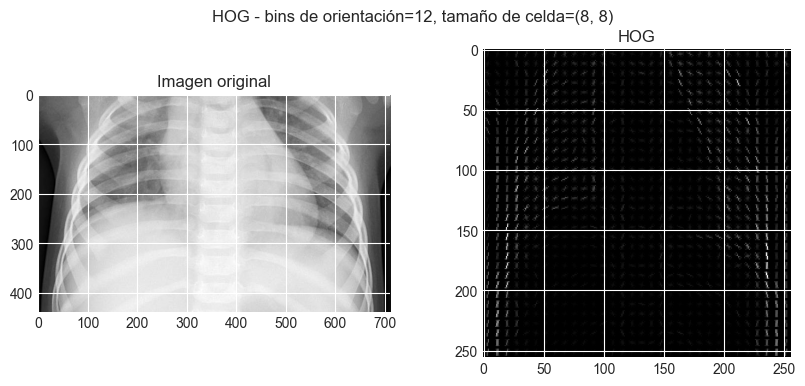

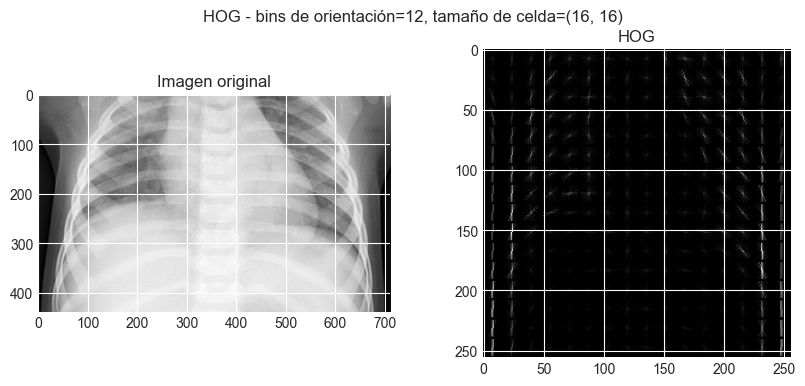

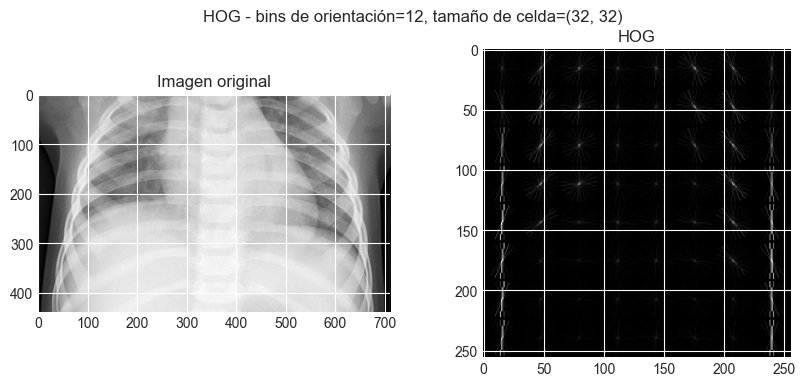

In [17]:
# Se prueban varios valores de bin de orientación y tamaños de celda con la imagén 1 del set pneumonia

orientations_list = [6, 9, 12]
cell_sizes = [(8,8), (16,16), (32,32)]

for ori in orientations_list:
    for cell in cell_sizes:
        features, hog_img = get_hog(
            img_example_p,
            orientations=ori,
            pixels_per_cell=cell
        )
        
        plt.figure(figsize=(10,4))
        plt.suptitle(f"HOG - bins de orientación={ori}, tamaño de celda={cell}")

        plt.subplot(1,2,1)
        plt.imshow(img_example_p, cmap='gray')
        plt.title("Imagen original")

        plt.subplot(1,2,2)
        plt.imshow(hog_img, cmap='gray')
        plt.title("HOG")

        plt.show()

## Descriptores de forma - Momentos de Hu

Los momentos de Hu son 7 valores numéricos que describen la forma de un objeto en una imagen, y al ser invariantes a la traslación, rotación o el escalamiento, esto los hace útiles en aplicaciones donde se requiera reconocer formas así estén en distintas orientaciones, posiciones y tamaños.  

In [18]:
# Se recorren todas las imágenes del folder train y se obtienen los momentos de Hu

classes = ["NORMAL", "PNEUMONIA"]

X_hu = []
y_hu = []

for class_name in classes:
    class_folder = os.path.join(TRAIN_DIR, class_name)

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Extraer momentos de Hu
        hu, _ = extract_hu_moments(img)

        X_hu.append(hu)
        y_hu.append(1 if class_name == "PNEUMONIA" else 0)

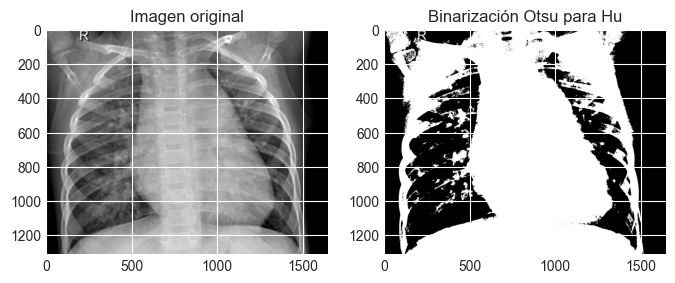

Momentos de Hu:
[  3.06723985   7.7982335   11.24589944  11.23948109  12.
 -11.99987005  12.        ]


In [19]:
# Visualizar cómo queda la imagen binarizada de un ejemplo del dataset pneumonia 

example_hu_path = PNEUMONIA_DIR/"person12_bacteria_46.jpeg"
example_hu = cv2.imread(example_hu_path, 0)
hu, seg = extract_hu_moments(example_hu)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_hu, cmap='gray')
plt.title("Imagen original")

plt.subplot(1,2,2)
plt.imshow(seg, cmap='gray')
plt.title("Binarización Otsu para Hu")
plt.show()

print("Momentos de Hu:")
print(hu)


#  Descripción de invarianzas proveeidas por los momentos de Hu

Los momentos de Hu son un conjunto de 7 descriptores que se utilizan para caracterizar la forma de un objeto en una imagen.


- Primer momento invariante - Hu 1
 
Captura la distribución general de la masa del objeto, en este caso la acumulación de líquido en los pulmones. El primer momento es invariante a cambios de escala, traslación y rotación y representa que tan extendida está la forma en la imagén.
 
- Momento de dispersión - Hu 2

EL segundo momento de Hu es el momento de dispersión, este distingue formas alargadas de formas más redondas. Así como el primer momento, este también es invariante a cambios de escala, traslación y rotación.

- Relación de simetría - Hu 3 

Detecta si la forma está equilibrada o sesgada hacia un lado. Es invariante a cambios de escala, traslación y rotación.

- Momento de curtosis de la forma - Hu 4 

Captura cambios de forma a nivel más complejo (cuarta orden) por lo que describe la dominancia de ciertas direcciones en la forma. Es invariante a cambios de escala, traslación y rotación.

- Invariante de simetría compleja - Hu 5 

Relaciona simetrías rotacionales de orden superior.  Es invariante a cambios de escala, traslación y rotación pero es muy sensible a reflexiones (espejado) en la imagen, es muy útil para distinguir curvas que cambian de dirección.

-  Asimetría en rotación - Hu 6

Es complementario al Hu 5, es un descriptor de simetría más avanzado que captura patrones de curvatura fina y que es invariante a cambios de escala, traslación y rotación.

-  Momento Hu 7

Es semi-variante lo que significa que cambia signo bajo reflexiones (operaciones de espejado), esto permite diferenciar formas que son idénticas excepto por ser un espejo. Es invariante a cambios de escala y traslación.







# Observaciones a resultados obtenidos por momentos de Hu

Al observar los valores obtenidos en el ejemplo:

Momentos de Hu:
[  3.06723985,   7.7982335,   11.24589944,  11.23948109,  12,
 -11.99987005,  12        ]

Se encuentra un Hu 1 bajo, lo que indica una forma relativamente compacta, el Hu 2 más alto significa que hay cierta elongación en la imagén. Los Hu 5, 6 y 7 con valores muy cercanos, sugieren una misma estructura global, es decir, patrones de simetría fina similares. Por último, al tener un Hu 7 de aproximadamente 12 se infiere que la forma no es simétrica bajo reflexión porque no hubo cambio de signo.

## Descriptores de forma - Descriptores de contorno : Área, perímetro, circularidad, excentricidad

Los descriptores de contornos son los más básicos en los que se puede pensar cuando se trata de detectar características en una imagen. Ya que estos son representaciones matemáticas que describen propiedades geométricas del contorno (borde) que rodea la región segmentada.

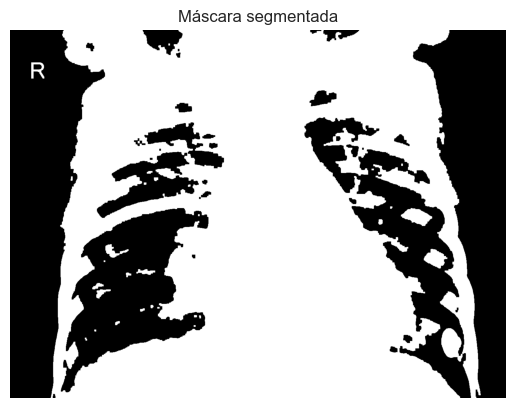


Descriptores morfológicos:
{'area': 1136304.0, 'perimeter': 10816.638191461563, 'circularity': 0.12204494422608839, 'eccentricity': np.float64(0.5124043636820586), 'contour': array([[[159,   0]],

       [[159,   1]],

       [[159,   2]],

       ...,

       [[162,   0]],

       [[161,   0]],

       [[160,   0]]], shape=(10052, 1, 2), dtype=int32)}


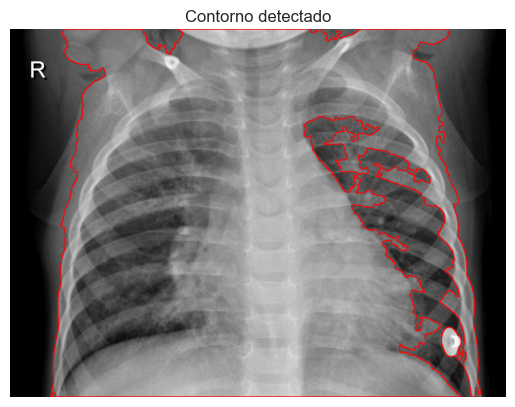

In [20]:
# Se segmenta una imagen del dataset train/pneumonia para extraer la región anatómica relevante en una imagen binaria

example_contour_path = PNEUMONIA_DIR/"person94_virus_176.jpeg"
example_contour = cv2.imread(example_contour_path, 0)
example_contour = cv2.cvtColor(example_contour, cv2.COLOR_BGR2RGB)



mask = segment_image(example_contour)

plt.imshow(mask, cmap="gray")
plt.title("Máscara segmentada")
plt.axis("off")
plt.show()

# Se obtienen los descriptores de contorno para la imagen segmentada mediante la función

desc = contour_descriptors(mask)
print("\nDescriptores morfológicos:")
print(desc)

# Dibujar contorno
img_cont = example_contour.copy()
cv2.drawContours(img_cont, [desc["contour"]], -1, (255,0,0), 2)

plt.imshow(img_cont)
plt.title("Contorno detectado")
plt.axis("off")
plt.show()

## Descriptores de textura - Local Binary Patterns (LBP)
Es un descriptor de textura ampliamente utilizado en el procesamiento de imagénes, fue propuesto inicialmente para describir texturas en imágenes de escala de grises. En este caso particular, es muy útil para detectar diferencias de texturas en los rayos X facilitando la tarea de clasicficación y procesamiento de la imagen en escala de grises que se recibe como entrada. 


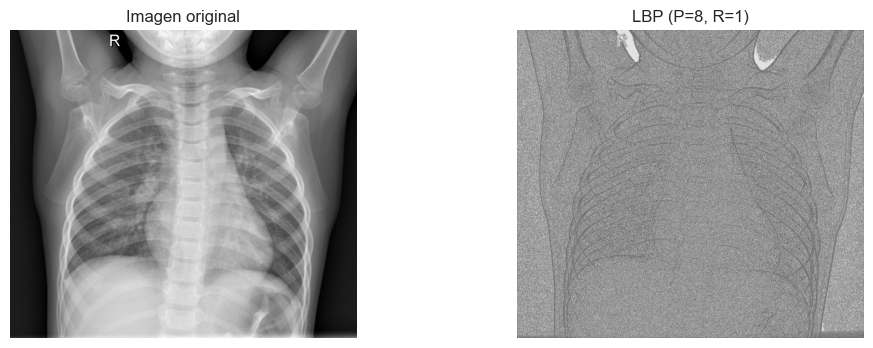

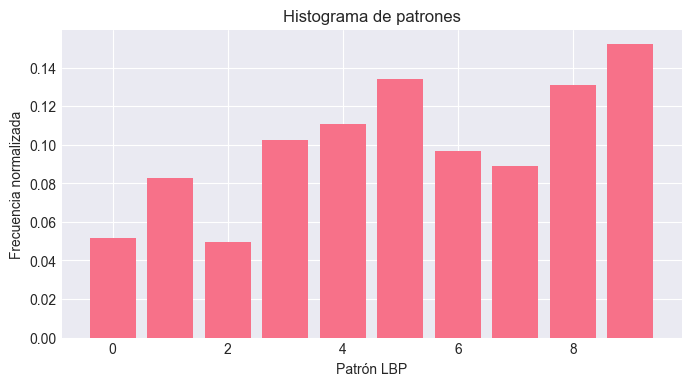

In [21]:
# Seleccionar una imagen del dataset train/normal, calcular el LBP por pixel y mostrar imagen binarizada

sample_path_lbp = next(NORMAL_DIR.glob("*.jpeg"))
img = load_image(sample_path_lbp)

lbp_img, lbp_hist = compute_lbp(img, P=8, R=1, method="uniform")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Imagen original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("LBP (P=8, R=1)")
plt.imshow(lbp_img, cmap='gray')
plt.axis('off')

plt.show()

# Calcular histograma de patrones por LBP

plt.figure(figsize=(8,4))
plt.title("Histograma de patrones")
plt.bar(np.arange(len(lbp_hist)), lbp_hist, width=0.8)
plt.xlabel("Patrón LBP")
plt.ylabel("Frecuencia normalizada")
plt.show()

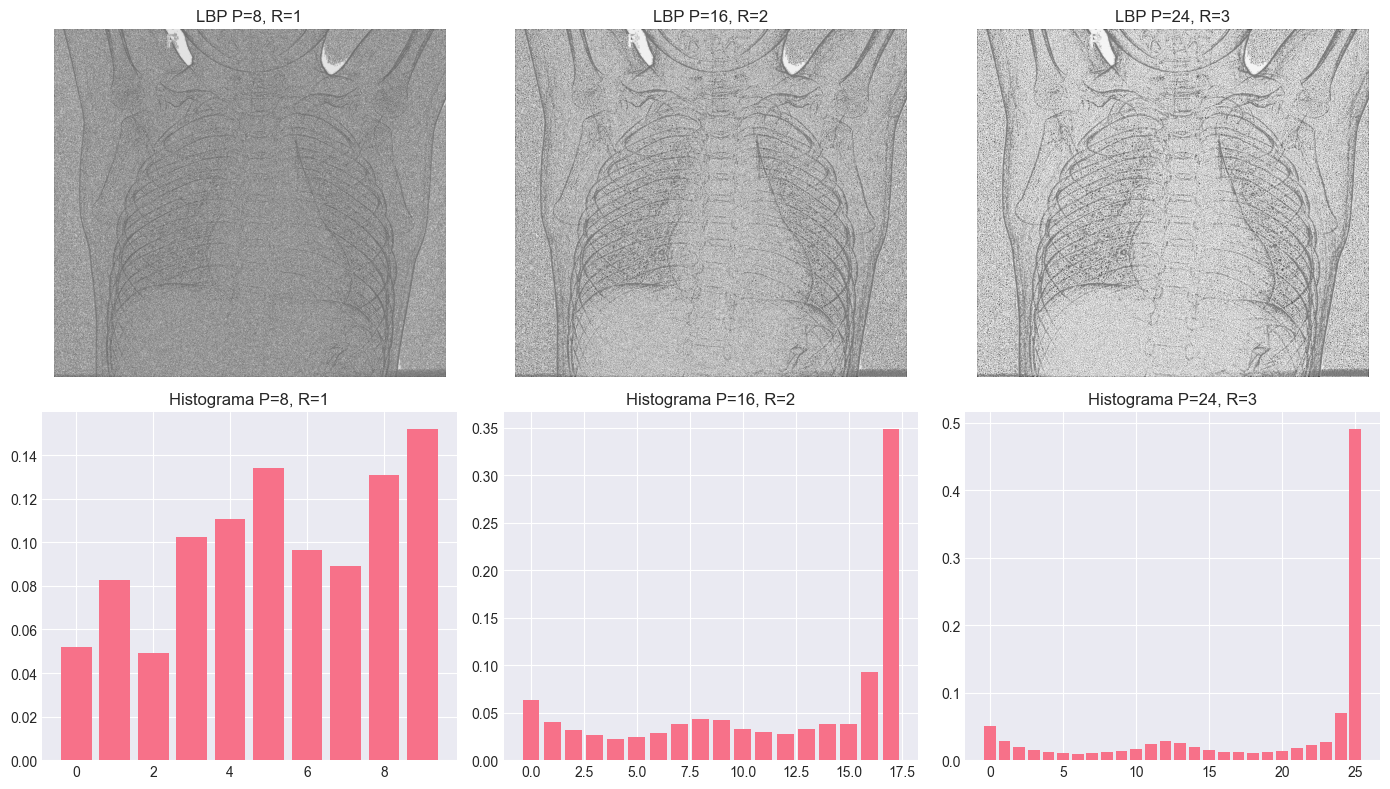

In [22]:
# Obtener LBP utilizando diferentes radios y puntos. Tupla (P,R)

configs = [
    (8,1),
    (16,2),
    (24,3),
]

plt.figure(figsize=(14,8))

for i,(P,R) in enumerate(configs,1):
    lbp_img, lbp_hist = compute_lbp(img, P=P, R=R)

    plt.subplot(2,len(configs),i)
    plt.title(f"LBP P={P}, R={R}")
    plt.imshow(lbp_img, cmap='gray')
    plt.axis('off')

    plt.subplot(2,len(configs),i+len(configs))
    plt.bar(np.arange(len(lbp_hist)), lbp_hist, width=0.8)
    plt.title(f"Histograma P={P}, R={R}")
    plt.tight_layout()

plt.show()

# Observaciones a resultados de Local Binary Patterns 

Se observa que a  mayor radio (R), se capturan patrones más globales. Así mismo, cuando se tiene un mayor número de puntos (P), se obtienen descriptores más detallados.

En este caso, para clasificación basada en imagénes de rayos X, funciona bien la configuración:

P = 16, R = 2

# Descriptores de textura - Gray Level Co-occurrence Matrix (GLCM)

Es un descriptor de textura que analiza cómo se relacionan pares de píxeles dentro de una imagen, a diferencia de los Local Binary Patterns que evalúa un pixel a la vez, la matriz GLCM analiza pares de píxeles separados por una cierta distancia y dirección. Se utiliza entre otras cosas para caracterizar lesiones o estructuras anatómicas en rayos X.

In [23]:
# Cargar una imagen de prueba para la matriz usando el dataset train/pneumonia

sample_path_GLCM = next((DATA_ROOT / "train" / "PNEUMONIA").glob("*.jpeg"))
img = cv2.imread(str(sample_path_GLCM), cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256,256))  # ajustar tamaño  de img a valores conocidos


# Calcular la matriz GLCM ante diferentes valores de ángulo y dirección.

glcm = glcm_manual(img, distances=[1,2], angles=[0, np.pi/4, np.pi/2])

# Tomar la primera combinación distancia=1, ángulo=0
g = glcm[:, :, 0, 0]

contrast, energy, homo, corr = glcm_props(g)

print(" Propiedad de Contraste GLCM:", contrast)
print(" Propiedad de Energía GLCM:", energy)
print("Propiedad de Homogeneidad GLCM:", homo)
print("Propiedad de Correlación GLCM:", corr)




 Propiedad de Contraste GLCM: 86.8021292892157
 Propiedad de Energía GLCM: 0.000697421814926951
Propiedad de Homogeneidad GLCM: 0.35799330715252153
Propiedad de Correlación GLCM: 0.9861446215521322


# Descriptores de textura - Filtro de Gabor

Es un filtro lineal sensible a frecuencia espacial y orientación.
Es similar a cómo las neuronas de la corteza visual humana responden a bordes y texturas. 
Es ampliamente utilizado en clasificación de imágenes médicas (Rayos X, TAC, RMN) y segmentación por frecuencia.

c:\Users\Andres Churio\Documents\TRABAJO-03\.venv\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Andres Churio\Documents\TRABAJO-03\.venv\Lib\site-packages\numpy\_core\_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Frecuencia=0.1, θ=0.00 rad → mean=0.156, std=inf
Frecuencia=0.1, θ=0.79 rad → mean=0.105, std=inf
Frecuencia=0.1, θ=1.57 rad → mean=0.150, std=inf
Frecuencia=0.1, θ=2.36 rad → mean=0.089, std=inf
Frecuencia=0.2, θ=0.00 rad → mean=0.118, std=inf
Frecuencia=0.2, θ=0.79 rad → mean=0.064, std=inf
Frecuencia=0.2, θ=1.57 rad → mean=0.074, std=inf
Frecuencia=0.2, θ=2.36 rad → mean=0.039, std=inf
Frecuencia=0.3, θ=0.00 rad → mean=0.079, std=inf
Frecuencia=0.3, θ=0.79 rad → mean=0.038, std=inf
Frecuencia=0.3, θ=1.57 rad → mean=0.070, std=inf
Frecuencia=0.3, θ=2.36 rad → mean=0.027, std=inf


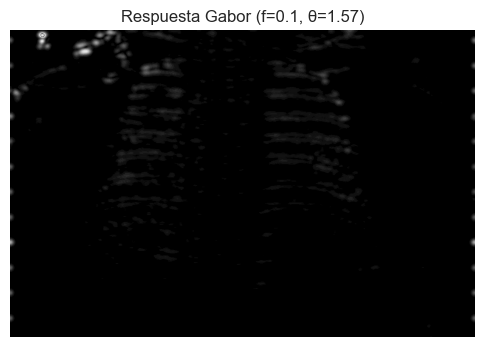

In [24]:
# Cargar una imagen del dataset train/pneumonia y aplicarle filtro de Gabor

sample_path_Gabor = next((DATA_ROOT / "train" / "PNEUMONIA").glob("*.jpeg"))
img_gabor = cv2.imread(str(sample_path_Gabor), cv2.IMREAD_GRAYSCALE)

frequencies = [0.1, 0.2, 0.3]
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]

responses = gabor_bank(img_gabor, frequencies, orientations)

for (f, th), data in responses.items():
    print(f"Frecuencia={f}, θ={th:.2f} rad → mean={data['mean']:.3f}, std={data['std']:.3f}")

# Visualizar la respuesta de Gabor

f, th = 0.1, np.pi/2
mag = responses[(f, th)]["magnitude"]

plt.figure(figsize=(6,6))
plt.imshow(mag, cmap="gray")
plt.title(f"Respuesta Gabor (f={f}, θ={th:.2f})")
plt.axis("off")
plt.show()